<a href="https://colab.research.google.com/github/rmkenv/newsletter/blob/main/Newsletter4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Performance on Test Set:
- R²: 0.986
- MAE: 1.55 kg CO2/hour

What Drives Your CO2 Emissions Most?
  gas: 0.83
  electricity: 0.10
  carbon_intensity: 0.06
  production: 0.01
  temperature: 0.00
  hour: 0.00
  dow: 0.00
  month: 0.00


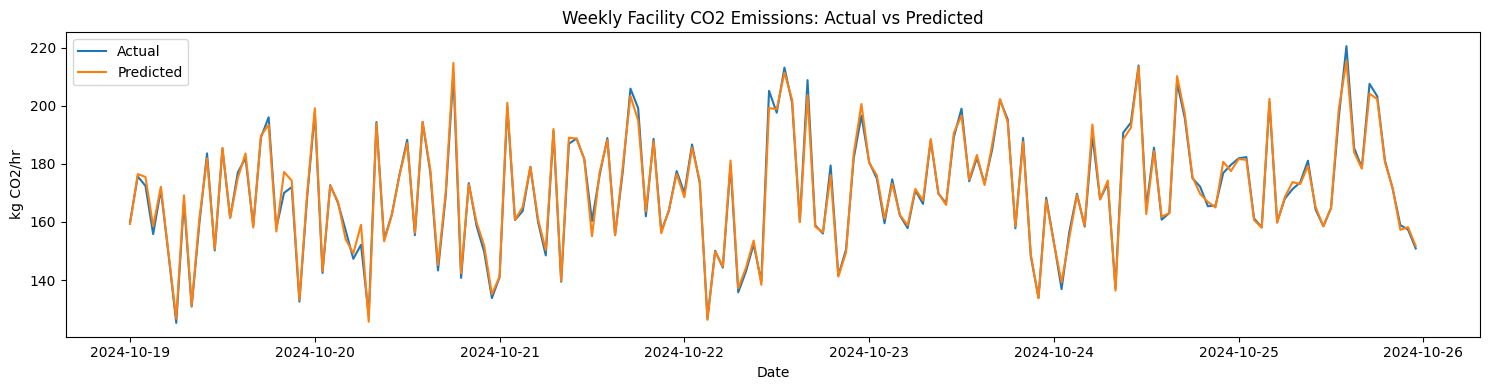

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ---- Step 1: Data Generation -----

np.random.seed(42)
n_hours = 24*365
dates = pd.date_range('2024-01-01', periods=n_hours, freq='h')

# Simulated plant characteristics
production = 70 + 20 * np.sin((dates.hour-8)*np.pi/12) * ((dates.hour >= 6) & (dates.hour <= 18))
production += -15 * (dates.dayofweek >= 5)
production += np.random.normal(0, 5, n_hours)
production = np.clip(production, 5, None)

temperature = 17 + 13 * np.sin((dates.dayofyear-60)*2*np.pi/365) + np.random.normal(0, 4, n_hours)
gas = 20 + np.maximum(18-temperature, 0) * 1.8 + 0.2*production + np.random.normal(0, 2, n_hours)
electricity = 40 + 0.9*production + np.random.normal(0, 6, n_hours)

# Simulate grid carbon intensity: higher in evenings, seasonal penalty in winter
carbon_intensity = 0.41 + 0.10*((dates.hour >= 17) & (dates.hour < 21)) + 0.07 * (np.cos((dates.dayofyear-180)*2*np.pi/365) > 0)
carbon_intensity += np.random.normal(0, 0.02, n_hours)
carbon_intensity = np.clip(carbon_intensity, 0.25, None)

# Process emissions as a direct function of output (with noise)
process = 4 + 0.04 * production + np.random.normal(0, 0.5, n_hours)
process = np.clip(process, 0, None)

# CO2 calculations
scope1 = gas * 2.2  # Direct fuel
scope2 = electricity * carbon_intensity  # Electricity
total_emissions = scope1 + scope2 + process

df = pd.DataFrame({
    'datetime': dates,
    'production': production,
    'gas': gas,
    'electricity': electricity,
    'temperature': temperature,
    'carbon_intensity': carbon_intensity,
    'scope1': scope1,
    'scope2': scope2,
    'process': process,
    'total_emissions': total_emissions,
    'hour': dates.hour,
    'dow': dates.dayofweek,
    'month': dates.month
})

# ---- Step 2: ML Model Building -----

features = ['production', 'gas', 'electricity', 'temperature', 'carbon_intensity', 'hour', 'dow', 'month']
target = 'total_emissions'
n_train = int(0.8*n_hours)

X_train = df[features].iloc[:n_train]
y_train = df[target].iloc[:n_train]
X_test = df[features].iloc[n_train:]
y_test = df[target].iloc[n_train:]

model = RandomForestRegressor(n_estimators=80, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# ---- Step 3: Model Assessment -----

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance on Test Set:")
print(f"- R²: {r2:0.3f}")
print(f"- MAE: {mae:0.2f} kg CO2/hour")

# Feature importance
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nWhat Drives Your CO2 Emissions Most?")
for f, imp in importances.items():
    print(f"  {f}: {imp:.2f}")

# Visualization
plt.figure(figsize=(15,4))
plt.plot(df['datetime'].iloc[n_train:n_train+168], y_test.iloc[:168], label='Actual')
plt.plot(df['datetime'].iloc[n_train:n_train+168], y_pred[:168], label='Predicted')
plt.title("Weekly Facility CO2 Emissions: Actual vs Predicted")
plt.ylabel("kg CO2/hr")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()